In [2]:
import numpy as np
import hickle as hkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rs
import os
import sys
import boto3
import yaml

sys.path.append('../src/')
from utils import quick_viz as make
%load_ext autoreload
%autoreload 2

## Conclusions
- A total of 255 tiles are affected by haze.
- In areas where resegmentation did not help the predictions, we expect the features to play a role. This notebook visualizes 65 features for neighboring haze affected tiles where resegmentation appeared successful (pd_east) and unsuccessful (pd_west).
- Artifacts are most extreme for the following feature indices pd_east: `10, 17, 19, 20, 31` and pd_west: `17, 19, 20, 23, 25, 28, 29, 31, 32, 40`. 
- The top 40 features used in the current model includes feature `42` which had strong artifacts in pd_west

## Example: resegmentation is successful

### ARD

In [2]:
tile_idx_a = (1656, 1068)
tile_idx_b = (1657, 1068)
ard_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/ard/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_ard.hkl')
ard_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/ard/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_ard.hkl')
for i in range(0, 13):
    make.heat_combine_neighbors(ard_a, ard_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

In [7]:
tile_idx_a = (1656, 1068)
tile_idx_b = (1657, 1068)
feats_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/raw/feats/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_feats.hkl')
feats_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/raw/feats/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_feats.hkl')
feats_a = np.rollaxis(feats_a, 0, 3)
feats_a = np.rollaxis(feats_a, 0, 2)
feats_b = np.rollaxis(feats_b, 0, 3)
feats_b = np.rollaxis(feats_b, 0, 2)
feats_a.shape, feats_b.shape

((618, 614, 65), (618, 614, 65))

In [4]:
for i in range(0, 65):
    make.heat_combine_neighbors(feats_a, feats_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

## Example: resegmentation is unsuccessful

### ARD

In [11]:
# tile_idx_a = (1647, 1079)
# tile_idx_b = (1648, 1079)
# ard_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/ard/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_ard.hkl')
# ard_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/ard/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_ard.hkl')
# for i in range(0, 5):
#     make.heat_combine_neighbors(ard_a, ard_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

### Features

In [188]:
tile_idx_a = (1675,1088)
tile_idx_b = (1676, 1088)
feats_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/raw/feats/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_feats.hkl')
feats_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/raw/feats/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_feats.hkl')
feats_a = np.rollaxis(feats_a, 0, 3)
feats_a = np.rollaxis(feats_a, 0, 2)
feats_b = np.rollaxis(feats_b, 0, 3)
feats_b = np.rollaxis(feats_b, 0, 2)
feats_a.shape, feats_b.shape

((618, 614, 65), (618, 614, 65))

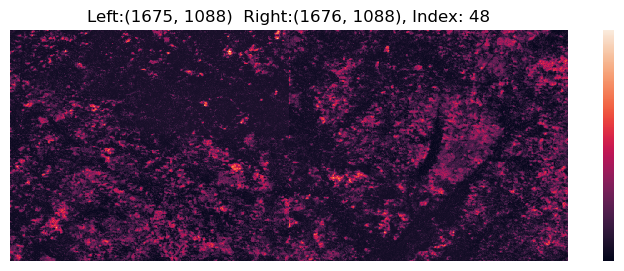

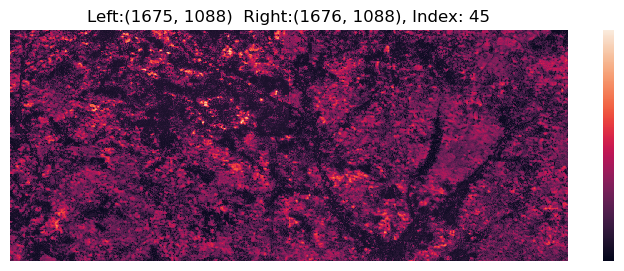

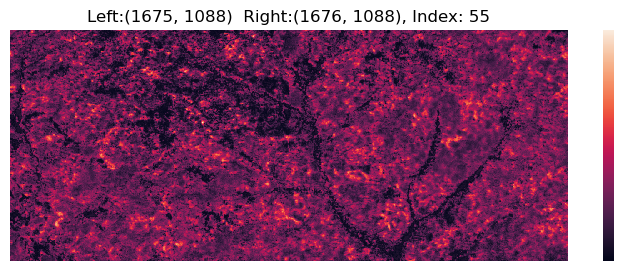

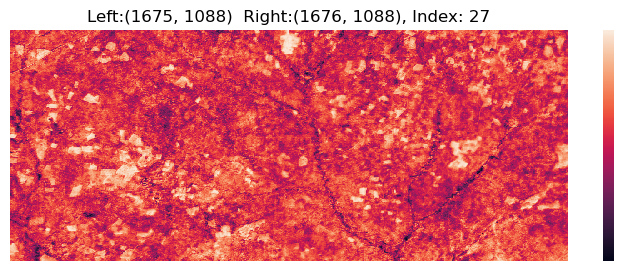

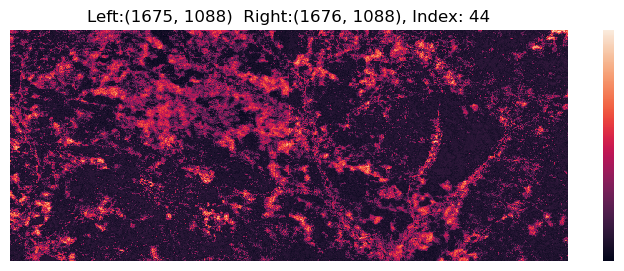

In [189]:

for i in [48, 45, 55, 27, 44]:
    make.heat_combine_neighbors(feats_a, feats_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

## Which features should be targeted?
top features for v25.5 model (current): `0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 20, 21, 24, 34, 42, 50, 52, 59, 60, 62, 63, 64, 65, 70, 71, 72, 73, 74, 76, 77, 84, 89, 90, 93`

In [38]:
east = [10, 17, 19, 20, 31]
west = [17, 19, 20, 23, 25, 28, 29, 31, 32, 40]
east = [i+13 for i in east]
west = [i+13 for i in west]
east, west

([23, 30, 32, 33, 44], [30, 32, 33, 36, 38, 41, 42, 44, 45, 53])

In [2]:
# north = pd.read_csv('../data/database/haze_pd_north.csv')
# east = pd.read_csv('../data/database/haze_pd_east.csv')
# west = pd.read_csv('../data/database/haze_pd_west.csv') 
# artifacts = pd.concat([north, east, west], axis=0, ignore_index=True)
#artifacts.to_csv('../data/database/haze_artifacts_full.csv')

In [115]:
artifacts

,Unnamed: 0,X,Y,Y_tile,X_tile,country,ADM2_EN,ADM1_EN,ADM0_EN,validOn,Area_ha,n,distance,feature_x,feature_y,nearest_x,nearest_y
75,75,-2.1389,9.4722,1134,1647,Ghana,West Gonja,Savannah,Ghana,2021/03/08,471598.235561,1,0.0,-2.1389,9.4722,-2.1389,9.4722
91,91,-2.1389,9.1944,1129,1647,Ghana,West Gonja,Savannah,Ghana,2021/03/08,471598.235561,1,0.0,-2.1389,9.1944,-2.1389,9.1944
101,101,-2.1389,9.1389,1128,1647,Ghana,West Gonja,Savannah,Ghana,2021/03/08,471598.235561,1,0.0,-2.1389,9.1389,-2.1389,9.1389
211,211,-2.1389,6.7500,1085,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.7500,-2.1389,6.7500
216,216,-2.1389,6.6944,1084,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.6944,-2.1389,6.6944
226,226,-2.1389,6.6389,1083,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.6389,-2.1389,6.6389
236,236,-2.1389,6.5833,1082,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.5833,-2.1389,6.5833
241,241,-2.1389,6.5278,1081,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.5278,-2.1389,6.5278
246,246,-2.1389,6.4722,1080,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.4722,-2.1389,6.4722
252,252,-2.1389,6.4167,1079,1647,Ghana,Atwima Mponua,Ashanti,Ghana,2021/03/08,188207.980174,1,0.0,-2.1389,6.4167,-2.1389,6.4167


<AxesSubplot: >

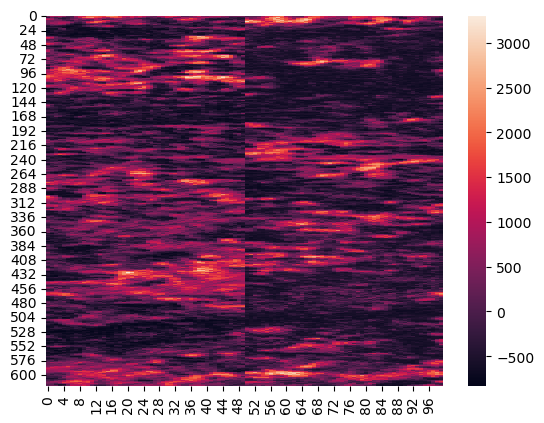

In [205]:
idx = 48
sns.heatmap(np.concatenate([lboundary[idx], rboundary[idx]], axis = 1))

In [206]:
artifacts = pd.read_csv('../data/database/haze_artifacts_full.csv')
# artifacts = artifacts[artifacts['X_tile'].isin([1647, 1648])]
# artifacts = artifacts.reset_index(drop = True)
total_differences = np.zeros((len(artifacts), 65)) # (255, 65)

counter = 0

# iterate through every tile id in artifacts and identify 
# if there is a neighboring tile
for i, val in artifacts.iterrows():
    left_x = val['X_tile']
    left_y = val['Y_tile']
    right_x = int(left_x) + 1
    right_y = int(left_y)
    check_neighbor = artifacts[(artifacts['X_tile'] == right_x) & (artifacts['Y_tile'] == right_y)] 
    if not check_neighbor.empty:
        folder = f'../tmp/ghana/'
        left = hkl.load(f'{folder}{str(left_x)}/{str(left_y)}/raw/feats/{str(left_x)}X{str(left_y)}Y_feats.hkl').astype(np.float32)
        right = hkl.load(f'{folder}{str(right_x)}/{str(right_y)}/raw/feats/{str(right_x)}X{str(right_y)}Y_feats.hkl').astype(np.float32)
        left = np.moveaxis(left, 1, 2)
        right = np.moveaxis(right, 1, 2)
        # shape is feats, rows, cols (65, 606, 618)
        #print(left.shape, right.shape)
        
        #How does the shift across the left tile to the right tile compare
        # to the shift within the left tile and the shift within the right tile
        # X1 X2 Y1 Y2
        # (X2 - Y1) compare to (X2 - X1) and (Y2 - Y1)
        lboundary = left[:, :, -2:] 
        rboundary = right[:, :, :2]
        
        # shape is feats, rows, cols (65, 606, 2)
        
        # Calculate the normalized difference across the boundary for each feature
        # something is wrong with this calculation?
        # diff 3100 mean 100 then the value would be 31
        #boundary_diff = np.mean(abs(lboundary - rboundary) / (np.mean(lboundary + rboundary) / 2), axis=(1, 2))
        #print(left.shape, right.shape)
        boundary_diff = abs(left[:, :, -1:] - right[:, :, :1])
        right_diff = abs(np.diff(right[..., :2], axis = -1))
        left_diff = abs(np.diff(left[..., -2:], axis = -1))
        nonboundary_diff = (right_diff + left_diff) / 2
        print(np.mean(boundary_diff[0]),
              np.mean(right_diff[0]),
              np.mean(left_diff[0]))
        #nonboundary_normfactor = np.std(nonboundary_diff, axis = 1).flatten()
        
        boundary_diff = np.median(boundary_diff / ((right_diff + left_diff) / 2), axis = 1).flatten()# / nonboundary_normfactor
        # this part is removed bc duplicated
         # Calculate the range for each feature
        #f_range = np.max(np.concatenate((lboundary, rboundary), axis=2), axis=(1, 2)) - np.min(np.concatenate((lboundary, rboundary), axis=2), axis=(1, 2))
        
        # Normalize the normalized difference by the feature range
        # dont need to normalize here?
        # norm_diff = boundary_diff / f_range

        # Store the result in total_differences
        boundary_diff[np.logical_or(np.isnan(boundary_diff), np.isinf(boundary_diff))] = 0
        total_differences[counter] = boundary_diff
        worst_ones = np.argsort(boundary_diff)[::-1][:5]
        print(f"For tiles {left_x, left_y} and {right_x, right_y} the boundary diff is {worst_ones}, {boundary_diff[worst_ones]}")
        
        counter += 1

22.28317 12.55178 6.461165
For tiles (1652, 1161) and (1653, 1161) the boundary diff is [48 25 14 27 53], [3.0485654 2.7593102 2.6277175 2.621456  2.4885528]


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_4568/957632668.py:48: RuntimeWarning: divide by zero encountered in divide
  boundary_diff = np.median(boundary_diff / ((right_diff + left_diff) / 2), axis = 1).flatten()# / nonboundary_normfactor
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_4568/957632668.py:48: RuntimeWarning: invalid value encountered in divide
  boundary_diff = np.median(boundary_diff / ((right_diff + left_diff) / 2), axis = 1).flatten()# / nonboundary_normfactor


53.43851 10.194175 5.446602
For tiles (1653, 1161) and (1654, 1161) the boundary diff is [61 55 38 46 36], [7.455739  4.436678  4.1727753 4.        3.4032521]
25.132687 13.205502 9.194175
For tiles (1661, 1160) and (1662, 1160) the boundary diff is [27 25 48 55 14], [4.0817776 4.043998  3.3570232 3.0351675 3.0296426]
16.443365 6.331715 10.247573
For tiles (1662, 1160) and (1663, 1160) the boundary diff is [27 18 25 48 45], [4.054887  3.2060606 3.1392913 2.8752108 2.8750296]
15.775081 8.378641 7.2961164
For tiles (1653, 1159) and (1654, 1159) the boundary diff is [28 25  9  3 26], [3.5811687 3.5292306 3.3536232 3.2974777 3.177116 ]
17.008091 8.380259 8.521035
For tiles (1654, 1159) and (1655, 1159) the boundary diff is [25  3 27 55 48], [3.9533875 3.7142565 3.6019802 3.2774549 3.1556134]
43.2945 9.961165 10.110032
For tiles (1653, 1158) and (1654, 1158) the boundary diff is [28 55 38 53 27], [4.2570753 3.7882    3.3798857 3.1915996 3.10922  ]
27.674757 10.616505 6.7297735
For tiles (165

21.435276 13.069579 7.524272
For tiles (1656, 1129) and (1657, 1129) the boundary diff is [27 25 55 48 14], [3.7864585 3.4493928 2.8133173 2.7535396 2.4377303]
24.962784 7.12945 11.7540455
For tiles (1660, 1129) and (1661, 1129) the boundary diff is [18 27 38 61  0], [4.085145  3.7867923 3.1188793 3.066885  3.0526316]
39.521034 11.907767 5.315534
For tiles (1661, 1129) and (1662, 1129) the boundary diff is [27  0 18 61 55], [5.38796   5.        4.4813385 4.057479  3.6478047]
8.393204 7.8398056 7.5323625
For tiles (1662, 1129) and (1663, 1129) the boundary diff is [27 25 14  3 48], [3.4180107 3.4017544 3.3460603 2.514261  2.5054803]
8.686084 10.891585 9.385114
For tiles (1646, 1128) and (1647, 1128) the boundary diff is [25 48  2 18  3], [2.5161505 2.2552176 2.254771  2.1026316 1.9790387]
11.618123 10.0711975 8.6035595
For tiles (1647, 1128) and (1648, 1128) the boundary diff is [18 27 55 25 20], [3.1945946 2.80625   2.6097398 2.5741758 2.5454545]
15.572816 12.647249 10.05178
For tiles 

2.3333333 1.2572815 0.7265372
For tiles (1664, 1076) and (1665, 1076) the boundary diff is [ 3 15 43 14 55], [2.4316888 2.2774587 2.123584  2.075036  2.0565944]
9.58576 4.2443366 2.39644
For tiles (1655, 1069) and (1656, 1069) the boundary diff is [61  3 44 11 12], [2.6608443 2.4824243 2.1994214 2.1698523 2.1126316]
7.694175 3.4838188 2.1294498
For tiles (1656, 1069) and (1657, 1069) the boundary diff is [ 3  5 61 15 18], [3.2060606 2.8396573 2.709527  2.6485295 2.4529915]
6.5064726 2.8608415 2.252427
For tiles (1657, 1069) and (1658, 1069) the boundary diff is [ 2  3  5 14  4], [5.0486026 3.2355103 3.115767  2.7775817 2.7188277]
17.05987 5.211974 5.3381877
For tiles (1658, 1069) and (1659, 1069) the boundary diff is [18  3 15 44 61], [3.438229  3.168352  3.        2.9379907 2.931712 ]
12.220065 5.079288 3.8090615
For tiles (1659, 1069) and (1660, 1069) the boundary diff is [11  2 18  3 61], [3.0638852 2.9873772 2.804762  2.7759907 2.649176 ]
10.477346 3.7572815 3.3511326
For tiles (16

5.105178 1.1326861 0.7378641
For tiles (1645, 1082) and (1646, 1082) the boundary diff is [ 3 29 14 12 18], [2.7850876 2.5108695 2.319556  2.2500477 2.207222 ]
5.1310678 4.004854 2.0695794
For tiles (1646, 1082) and (1647, 1082) the boundary diff is [61 29 26 12  5], [2.162143  2.108425  1.9089026 1.8530576 1.8289199]
12.323625 7.3737864 5.291262
For tiles (1643, 1081) and (1644, 1081) the boundary diff is [18 27  3 26 55], [2.875     2.845984  2.6277175 2.5323887 2.3627157]
6.4126215 4.211974 3.195793
For tiles (1644, 1081) and (1645, 1081) the boundary diff is [26 15  5  3 18], [2.6566844 2.3964858 2.155862  2.0305986 2.       ]
6.909385 1.8818771 2.6278317
For tiles (1645, 1081) and (1646, 1081) the boundary diff is [12 29 17 14  3], [2.8208556 2.7841616 2.7604985 2.7523584 2.5617075]
8.739482 3.7556634 3.4110034
For tiles (1646, 1081) and (1647, 1081) the boundary diff is [12  3 11 45  2], [2.2552328 2.        1.946772  1.923093  1.9149828]
6.9919095 3.2653723 1.3381877
For tiles (

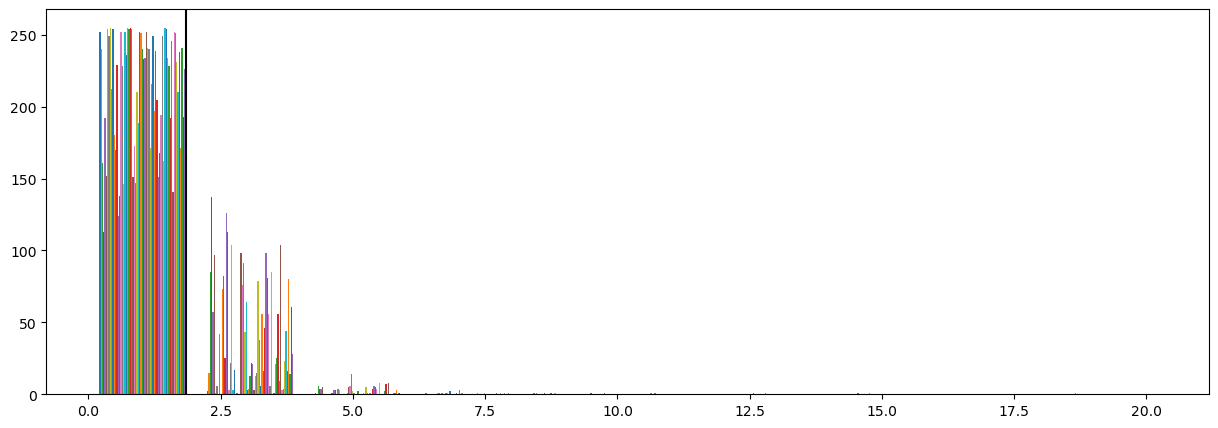

In [212]:
# plot the histogram to identify appropriate min / max ranges for outliers
threshold = 1.85
plt.figure(figsize=(15,5))
plt.hist(total_differences);
plt.axvline(x=threshold, color='black')

In [54]:
total_differences[np.isinf(total_differences)] = 0.

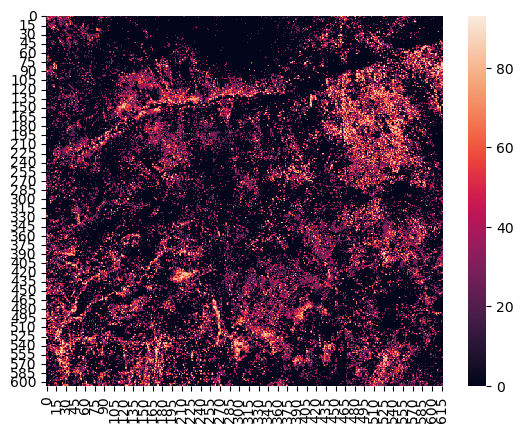

In [25]:
sns.heatmap(left[0, :, :], xticklabels=15, yticklabels=15,);

In [213]:
# higher values are sharper artifacts
# Cast total differences to boolean where its true if its an outlier and false if not
# where each value is the fraction of 255 samples that are outside of range for x feature

threshold = 1.85

# min and max values are selected based on hist above
output = np.mean(np.logical_or(total_differences >= threshold, total_differences <= -threshold), axis = 0)

In [214]:
#of the top 40 features ranked by the artifacts, which are in the model features?
topfeatures = np.argsort(output)[::-1][:32] # IS THIS high low or low high?
#bestfeatures = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 20, 21, 24, 34, 42, 50, 52, 59, 60, 62, 63, 64, 65, 70, 71, 72, 73, 74, 76, 77, 84, 89, 90, 93]
#sorted([x for x in topfeatures if x in bestfeatures])
topfeatures

array([ 3, 14, 15, 55, 27, 18, 44,  5, 11, 12,  2, 38, 45, 25, 26, 61, 48,
       29, 53,  4, 46, 41, 63,  9, 43, 28, 59, 39, 64, 52, 13, 58])

In [215]:
np.sort(output)[::-1] * 255

array([157., 153., 145., 134., 126., 126., 124., 121., 117., 117., 112.,
       112., 111., 111., 109., 106., 103.,  98.,  86.,  82.,  80.,  77.,
        76.,  74.,  72.,  59.,  57.,  55.,  48.,  43.,  42.,  41.,  38.,
        38.,  36.,  29.,  28.,  26.,  26.,  23.,  22.,  21.,  20.,  20.,
        13.,  11.,  11.,  10.,   8.,   7.,   7.,   7.,   6.,   4.,   4.,
         4.,   3.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.])

In [102]:
np.sort(output)[::-1][31] * 255

3.0

In [103]:
output

array([0.        , 0.02352941, 0.01568627, 0.05490196, 0.01176471,
       0.01568627, 0.01176471, 0.        , 0.        , 0.        ,
       0.        , 0.00784314, 0.00784314, 0.        , 0.15686275,
       0.01568627, 0.01568627, 0.1372549 , 0.10980392, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1254902 , 0.00392157, 0.04705882, 0.01568627, 0.01176471,
       0.00392157, 0.00784314, 0.00784314, 0.        , 0.00392157,
       0.        , 0.01176471, 0.01176471, 0.02352941, 0.00392157,
       0.        , 0.00392157, 0.02352941, 0.02352941, 0.04705882,
       0.03529412, 0.        , 0.00392157, 0.02745098, 0.        ,
       0.        , 0.01176471, 0.        , 0.02745098, 0.        ,
       0.01176471, 0.        , 0.        , 0.01568627, 0.        ,
       0.01176471, 0.03921569, 0.01176471, 0.01176471, 0.01960784])

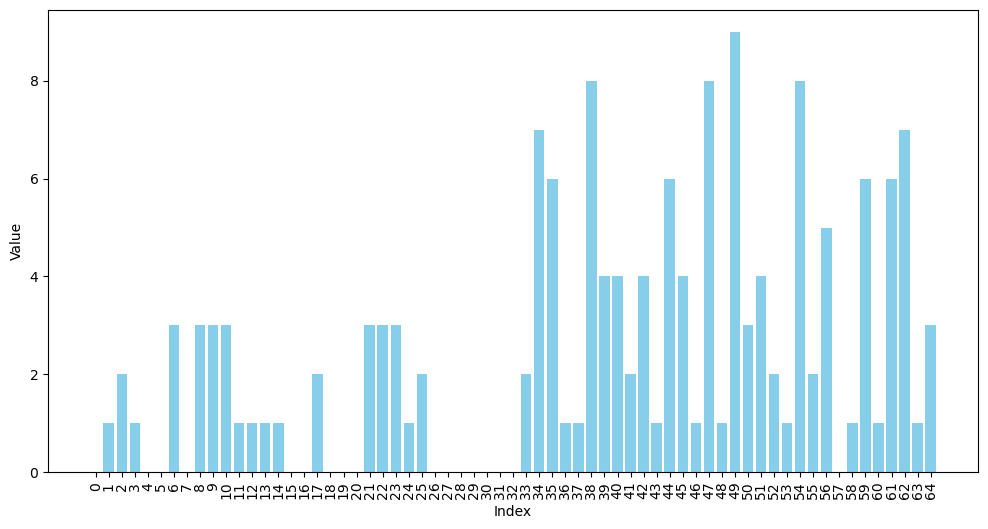

In [22]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(output)), output * 255, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(range(len(output)))
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [9]:
np.unique(output)

array([0.00392157, 0.03137255, 0.04705882, 0.05882353, 0.0627451 ,
       0.0745098 , 0.07843137, 0.08627451, 0.09411765, 0.09803922,
       0.10196078, 0.10588235, 0.10980392, 0.11372549, 0.12156863,
       0.12941176, 0.13333333, 0.1372549 , 0.14117647, 0.15294118,
       0.16078431, 0.16470588, 0.16862745, 0.17254902, 0.18431373,
       0.19215686, 0.19607843, 0.2       , 0.20784314, 0.23137255,
       0.23529412, 0.24705882, 0.25882353, 0.2745098 , 0.30196078,
       0.30588235, 0.30980392, 0.32941176, 0.33333333, 0.34901961,
       0.36470588, 0.36862745, 0.38039216, 0.39215686, 0.39607843,
       0.40784314, 0.44313725, 0.45490196])

In [10]:
len(output)

65